In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from dateutil.relativedelta import relativedelta

In [2]:
date_of_birth = pd.datetime(1991,2,23)
height = 183
sex = 'm'
exercise_level = 1
fill_missing_dates = False
calories_path = 'demo_calories.csv'
weight_path = 'demo_weight.csv'
planned_deficit = 300
use_bodyfat = False

In [3]:
df_calories = pd.read_csv(calories_path, parse_dates=['ts'])

In [4]:
df_calories.tail()

,ts,item,calories
26,2019-01-13,daily,2650
27,2019-01-14,daily,1799
28,2019-01-15,daily,1832
29,2019-01-16,daily,2057
30,2019-01-17,daily,2110


In [5]:
df_weight = pd.read_csv(weight_path, parse_dates=['ts'])
df_weight['weight_avg'] = pd.np.nanmean(df_weight[['weight_am', 'weight_pm']], axis=1)
df_weight['bodyfat'] = df_weight['bodyfat'].fillna(method='ffill')
df_weight = df_weight.set_index('ts')

In [6]:
df_weight.tail()

,weight_am,weight_pm,bodyfat,weight_avg
ts,,,,
2019-01-13,82.5,82.5,19.0,82.50
2019-01-14,82.1,82.9,20.0,82.50
2019-01-15,82.2,82.6,20.0,82.40
2019-01-16,82.4,82.3,20.0,82.35
2019-01-17,82.0,82.5,19.0,82.25


In [7]:
df_calories_daily = df_calories.groupby(pd.Grouper(freq='D', key='ts')).agg({'calories': 'sum'}).reset_index()
df_calories_daily['age'] = df_calories_daily.apply(lambda row: relativedelta(row.ts, date_of_birth).years, axis=1)
df_calories_daily = df_calories_daily.set_index('ts')
df_calories_daily.tail()

,calories,age
ts,,
2019-01-13,2650,27
2019-01-14,1799,27
2019-01-15,1832,27
2019-01-16,2057,27
2019-01-17,2110,27


In [8]:
df_calories_weight = df_calories_daily
df_calories_weight['weight'] = df_weight['weight_avg']
df_calories_weight['bodyfat'] = df_weight['bodyfat']

In [9]:
def daily_maintenance_rate(age,height,weight,sex,bodyfat,exercise_level): 
    exercise_factor = (1.2+exercise_level*0.175)
    
    if use_bodyfat and bodyfat:
        return 370+(21.6*(weight*1-bodyfat/100))*exercise_factor
    
    s = 5
    if sex != "m": s = -161
    
    mifflin = 10*weight+6.25*height-5*age + s
    
    return mifflin*exercise_factor

In [10]:
df_calories_weight['tdee'] = df_calories_weight.apply(lambda row: daily_maintenance_rate(row.age,height,row.weight,sex,row.bodyfat,exercise_level), axis=1)

In [11]:
if fill_missing_dates:
    df_calories_weight['tdee'] = df_calories_weight['tdee'].interpolate(method="linear")
    df_calories_weight['calories'] = df_calories_weight['calories'].replace(0, pd.np.nan).interpolate(method="linear")
    df_calories_weight['weight'] = df_calories_weight['weight'].interpolate(method="linear")
    df_calories_weight['bodyfat'] = df_calories_weight['bodyfat'].interpolate(method="linear")

In [12]:
df_calories_weight['deficit'] = df_calories_weight['tdee'] - df_calories_weight['calories']
df_calories_weight['deficit_cumsum'] = df_calories_weight['deficit'].cumsum()

df_calories_weight['planned_deficit'] = planned_deficit
df_calories_weight['planned_deficit_cumsum'] = df_calories_weight['planned_deficit'].cumsum()

df_calories_weight['deficit_mean'] = df_calories_weight['deficit'].expanding().mean()

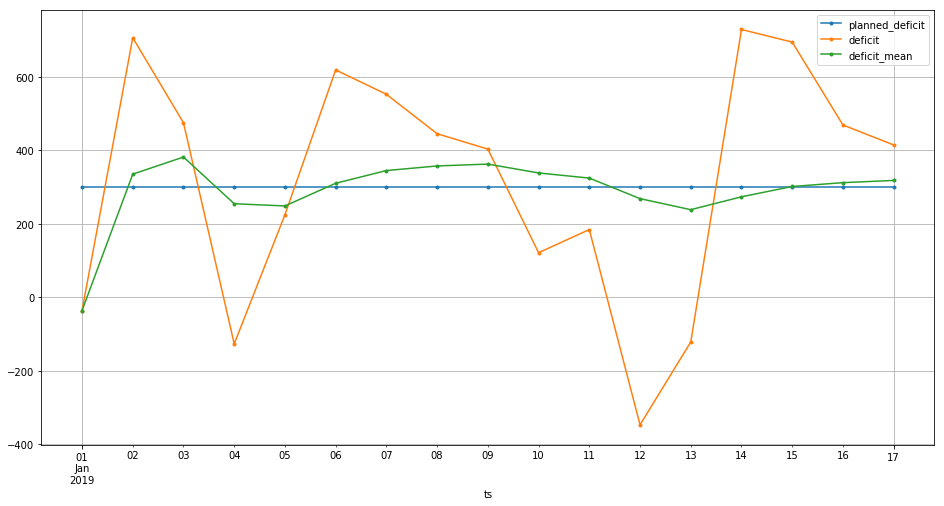

In [13]:
df_calories_weight[['planned_deficit', 'deficit', 'deficit_mean']].dropna().plot(grid=True,figsize=(16,8), style=".-")
plt.show()

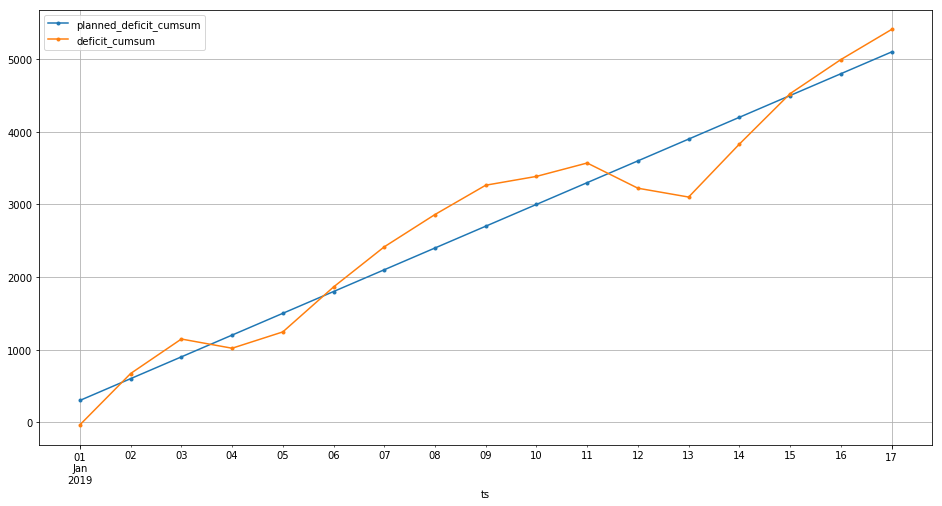

In [14]:
df_calories_weight[['planned_deficit_cumsum', 'deficit_cumsum']].dropna().plot(grid=True,figsize=(16,8), style=".-")
plt.show()

In [15]:
df_calories_weight['expected_weight'] = df_calories_weight['weight'].iloc[0] - df_calories_weight['deficit_cumsum']/3500*0.45
df_calories_weight['planned_weight'] = df_calories_weight['weight'].iloc[0] - df_calories_weight['planned_deficit_cumsum']/3500*0.45

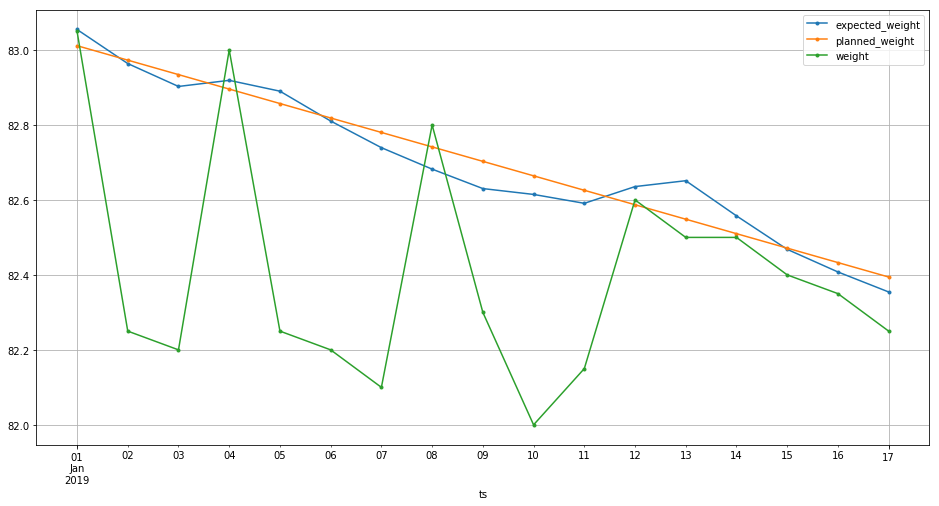

In [16]:
df_calories_weight[['expected_weight','planned_weight', 'weight']].dropna().plot(grid=True,figsize=(16,8), style='.-')
plt.show()